In [31]:
using ITensors
using Plots
using JLD2
using Base.Threads
using StatsBase
using HDF5
include("../sampling.jl");

In [2]:
function loadMPS(path::String; id::String="W")
    """Loads an MPS from a .h5 file. Returns and ITensor MPS."""
    file = path[end-2:end] != ".h5" ? path * ".h5" : path
    f = h5open("$file","r")
    mps = read(f, "$id", MPS)
    close(f)
    return mps
end
function sliceMPS(W::MPS, class_label::Int)
    """General function to slice the MPS and return the state corresponding to a specific class label."""
    ψ = deepcopy(W)
    decision_idx = findindex(ψ[end], "f(x)")
    decision_state = onehot(decision_idx => (class_label + 1))
    ψ[end] *= decision_state
    normalize!(ψ) # same step as before - normalise the tensor at the site with the label index instead?

    return ψ
end;

In [3]:
mps_loaded = loadMPS("/Users/joshua/Documents/QuantumInspiredML/LogLossAlternative/generative_experiment/saved_data/1000_samples/chi100_mps.h5");

In [4]:
norm(mps_loaded)

1.0000000000000047

In [5]:
state0 = sliceMPS(mps_loaded, 0)
state1 = sliceMPS(mps_loaded, 1);

In [6]:
all_shots_c0 = Matrix{Float64}(undef, 5000, 100)
for i in 1:5000
    println(i)
    all_shots_c0[i, :] = sample_mps_with_contractions(state0)
end

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [7]:
mean_ts = mean(all_shots_c0, dims=1)[1,:]
std_ts = std(all_shots_c0, dims=1)[1,:]

100-element Vector{Float64}:
 0.28149126415173603
 0.2838979991398918
 0.2839467872341276
 0.2837522790544941
 0.28213086728559456
 0.28067799140368754
 0.2827964534176395
 0.2846056927368233
 0.2832571267293337
 0.283413005350692
 ⋮
 0.28493361177943805
 0.2828344088800649
 0.2822104771968485
 0.2817473158331648
 0.28590800016430046
 0.2852250619481189
 0.2829443386561351
 0.2856010637725539
 0.28053848782279234

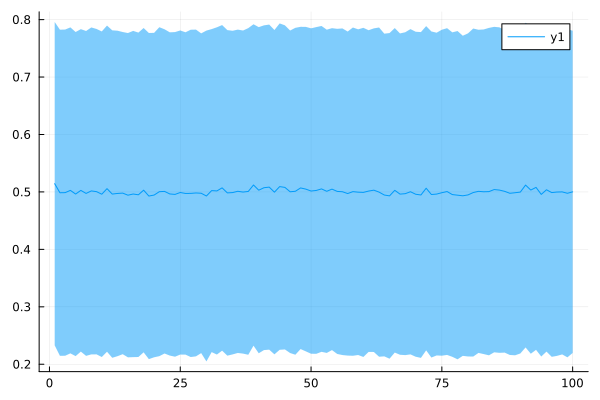

In [13]:
plot(mean_ts, ribbon=std_ts)

In [10]:
@load "train_chi50.jld2"

2-element Vector{Symbol}:
 :X_train_scaled
 :y_train

In [11]:
c0_idxs = findall(x -> x.== 0, y_train);
c1_idxs = findall(x -> x.== 1, y_train);
c0_samples = X_train_scaled[c0_idxs, :];
c1_samples = X_train_scaled[c1_idxs, :];

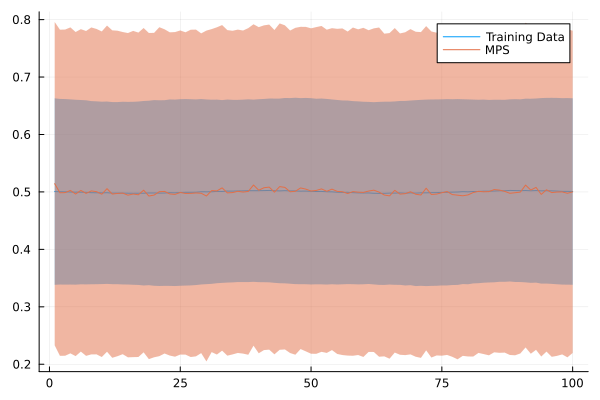

In [17]:
plot(mean(c0_samples, dims=1)[1,:], ribbon=std(c0_samples, dims=1)[1,:], label="Training Data")
plot!(mean_ts, ribbon=std_ts, label="MPS")

In [7]:
@load "/Users/joshua/Documents/QuantumInspiredML/LogLossAlternative/generative_experiment/saved_data/1000_samples/chi100_test.jld2"

2-element Vector{Symbol}:
 :X_test_scaled
 :y_test

In [8]:
c0_test_idxs = findall(x -> x.== 0, y_test);
c1_test_idxs = findall(x -> x.== 1, y_test);
c0_test_samples = X_test_scaled[c0_test_idxs, :];
c1_test_samples = X_test_scaled[c1_test_idxs, :];

In [34]:
all_shots_forecast = Matrix{Float64}(undef, 500, 100)
for i in 1:500
    println(i)
    all_shots_forecast[i, :] = forecast_mps_sites(state0, c0_test_samples[29,1:50], 51)
end

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


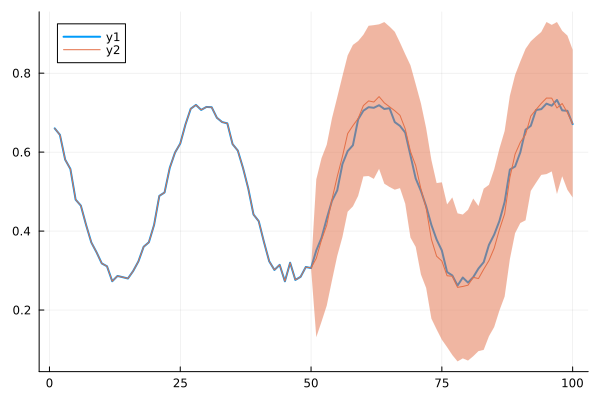

In [35]:
plot(c0_test_samples[29,:], lw=2)
plot!(mean(all_shots_forecast, dims=1)[1,:], ribbon=std(all_shots_forecast, dims=1)[1,:])

In [24]:
all_shots_forecast1000 = Matrix{Float64}(undef, 500, 100)
for i in 1:500
    all_shots_forecast1000[i, :] = forecast_mps_sites(state1, c1_test_samples[34,1:50], 51)
end

1
251
126
376
252
377
2
127
253
3
128
378
254
4
379
129
255
5
380
130
256
6
381
131
257
382
7
132
258
8
383
133
259
9
384
134
260
10
385
135
261
11
136
386
262
12
387
137
263
13
138
388
264
14
139
389
265
15
390
266
140
16
391
267
141
17
392
268
142
18
393
269
143
19
394
144
270
20
395
145
271
21
396
272
146
22
397
273
147
23
398
274
148
24
399
275
149
25
400
150
276
26
401
277
151
27
402
278
152
28
403
153
279
29
404
154
280
30
405
155
281
31
406
156
282
32
407
157
283
33
408
158
284
34
409
159
285
35
410
160
286
36
411
161
287
37
412
288
162
38
413
289
163
39
414
164
290
40
415
165
291
41
416
292
166
42
417
293
43
167
418
294
168
44
419
45
295
169
420
296
170
46
421
171
297
47
422
172
298
48
423
173
299
49
424
174
300
50
425
175
301
51
426
176
302
52
427
177
53
303
428
178
54
429
304
179
55
430
305
180
56
431
306
181
57
432
182
307
433
58
183
308
434
59
309
184
435
60
310
185
436
61
311
186
437
62
187
312
438
63
313
188
64
439
314
189
65
440
315
190
66
441
316
191
67
442
317
192
68
4

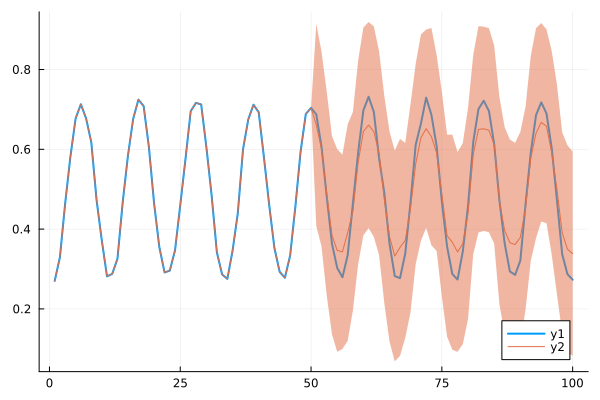

In [25]:
plot(c1_test_samples[34,:], lw=2)
#plot!(mean(all_shots_forecast, dims=1)[1,:], ribbon=std(all_shots_forecast, dims=1)[1,:])
plot!(mean(all_shots_forecast1000, dims=1)[1,:], ribbon=std(all_shots_forecast1000, dims=1)[1,:])
#plot!(mean(all_shots_forecast100, dims=1)[1,:], ribbon=std(all_shots_forecast100, dims=1)[1,:])